In [2]:
import pandas as pd
import geopandas as gpd
import os
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# OA11 -> OA21 conversion
oa_21 = gpd.read_file(os.path.join('data','oa11tooa21.geojson'))

In [4]:
# read the shapefile OA, add OA21 from gdf_21
oa = gpd.read_file(os.path.join('data','statistical-gis-boundaries-london','ESRI','OA_2011_London_gen_MHW.shp'))
oa['OA21CD'] = oa['OA11CD'].map(oa_21.set_index('OA11CD')['OA21CD'])

# read the flow file
df = pd.read_csv(os.path.join('data','flow','ODWP01EW_OA_v1','ODWP01EW_OA.csv'))

<Axes: >

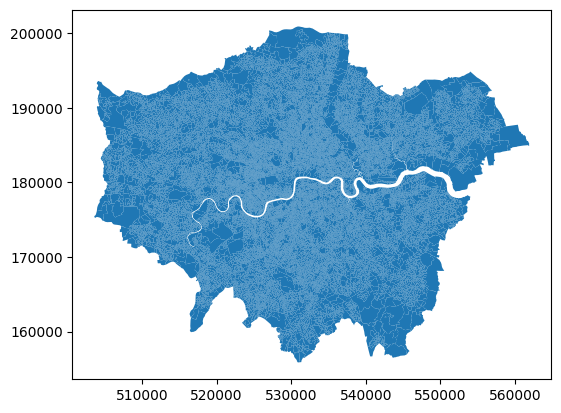

In [5]:
# plot gdf
oa.plot()

In [6]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10741185 entries, 0 to 10741184
Data columns (total 7 columns):
 #   Column                                        Dtype 
---  ------                                        ----- 
 0   Output Areas code                             object
 1   Output Areas label                            object
 2   OA of workplace code                          object
 3   OA of workplace label                         object
 4   Place of work indicator (4 categories) code   int64 
 5   Place of work indicator (4 categories) label  object
 6   Count                                         int64 
dtypes: int64(2), object(5)
memory usage: 573.6+ MB


<Axes: >

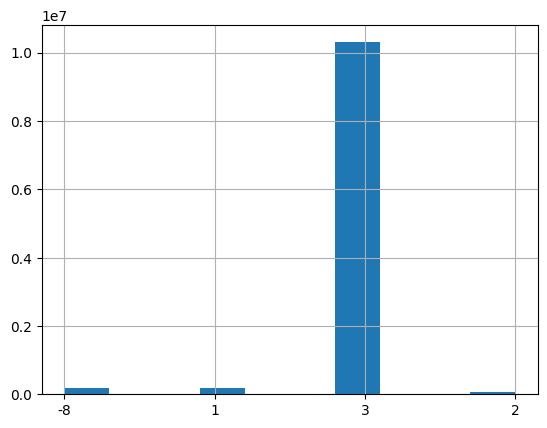

In [7]:
# visualise split of commuting pattern
df.iloc[:,4].astype('string').hist()

In [8]:
#filter forpalce of work indicator 3 (non work-from-home)
df_commute = df[df['Place of work indicator (4 categories) code'] == 3]
#filter for place where Output Areas code differs from OA of workplace code
df_commute = df_commute[df_commute['OA of workplace code'] != df_commute['Output Areas code']]
df_commute.head()

,Output Areas code,Output Areas label,OA of workplace code,OA of workplace label,Place of work indicator (4 categories) code,Place of work indicator (4 categories) label,Count
2,E00000001,E00000001,E00004731,E00004731,3,Working in the UK but not working at or from home,1
3,E00000001,E00000001,E00006038,E00006038,3,Working in the UK but not working at or from home,1
4,E00000001,E00000001,E00013547,E00013547,3,Working in the UK but not working at or from home,1
5,E00000001,E00000001,E00013548,E00013548,3,Working in the UK but not working at or from home,1
6,E00000001,E00000001,E00013789,E00013789,3,Working in the UK but not working at or from home,1


In [9]:
#group by OA of workplace code, summarise by count
df_commute_grouped = df_commute.groupby('OA of workplace code').count()
df_commute_grouped = df_commute_grouped.reset_index()
df_commute_grouped = df_commute_grouped[['OA of workplace code','Count']]


In [10]:
# join the two dataframes, rename the column
oa_joined = oa.merge(df_commute_grouped, left_on='OA21CD', right_on='OA of workplace code', how='left') \
                .drop(columns=['OA of workplace code']) \
                .rename(columns={'Count':'count_commuters'})


In [31]:
import h3
res = 9

# get centroid of each OA
oa_joined_pt = oa_joined.copy()
oa_joined_pt['geometry'] = oa_joined['geometry'].centroid
oa_joined_pt = oa_joined_pt.set_geometry('geometry')
oa_joined_pt.to_crs(epsg=4326, inplace=True)

def lat_lng_to_h3(row):
    return h3.geo_to_h3(
        row.geometry.y, row.geometry.x, res
    )

od_h3_count = oa_joined_pt.copy()
od_h3_count ["h3"] = od_h3_count .apply(lat_lng_to_h3, axis = 1)
od_h3_count.head()

,OA11CD,LSOA11CD,MSOA11CD,WD11CD_BF,WD11NM_BF,LAD11CD,LAD11NM,RGN11CD,RGN11NM,LSOA11NM,...,USUALRES,HHOLDRES,COMESTRES,POPDEN,HHOLDS,AVHHOLDSZ,geometry,OA21CD,count_commuters,h3
0,E00023264,E01004612,E02000954,E05000626,Tooting,E09000032,Wandsworth,E12000007,London,Wandsworth 032C,...,462,459,3,115.2,143,3.2,POINT (-0.16688 51.43219),E00023264,7.0,89194adad7bffff
1,E00003359,E01000692,E02000128,E05000111,Chislehurst,E09000006,Bromley,E12000007,London,Bromley 002D,...,269,259,10,36.7,133,1.9,POINT (0.06683 51.41932),E00003359,323.0,89194ad2937ffff
2,E00023266,E01004615,E02000956,E05000626,Tooting,E09000032,Wandsworth,E12000007,London,Wandsworth 034B,...,277,277,0,183.4,133,2.1,POINT (-0.17908 51.43163),E00023266,NaN,89194ada8a3ffff
3,E00020264,E01004027,E02000809,E05000548,Riverside,E09000028,Southwark,E12000007,London,Southwark 003E,...,415,415,0,96.1,191,2.2,POINT (-0.07781 51.50188),E00020264,200.0,89194ad3393ffff
4,E00023263,E01004613,E02000955,E05000626,Tooting,E09000032,Wandsworth,E12000007,London,Wandsworth 033D,...,304,304,0,165.2,131,2.3,POINT (-0.16204 51.43202),E00023263,27.0,89194adad73ffff


In [32]:
# Converto to polygons to visualise
from shapely.geometry import Polygon

def add_geometry(row):
    points = h3.h3_to_geo_boundary(row["h3"],True)
    return Polygon(points)

#geometry column
od_h3_count["geometry"] = od_h3_count.apply(add_geometry, axis = 1)

#convert gdf
od_h3_count = gpd.GeoDataFrame(od_h3_count, crs = "EPSG:4326")
od_h3_count.tail()

,OA11CD,LSOA11CD,MSOA11CD,WD11CD_BF,WD11NM_BF,LAD11CD,LAD11NM,RGN11CD,RGN11NM,LSOA11NM,...,USUALRES,HHOLDRES,COMESTRES,POPDEN,HHOLDS,AVHHOLDSZ,geometry,OA21CD,count_commuters,h3
25048,E00004047,E01000828,E02000137,E05000126,Shortlands,E09000006,Bromley,E12000007,London,Bromley 011E,...,349,349,0,43.7,117,3.0,"POLYGON ((0.00078 51.40143, -0.00131 51.40045,...",E00004047,NaN,89194ad0d6bffff
25049,E00007044,E01001420,E02000296,E05000196,Cockfosters,E09000010,Enfield,E12000007,London,Enfield 020B,...,288,288,0,30.5,114,2.5,"POLYGON ((-0.14320 51.64392, -0.14530 51.64294...",E00007044,25.0,89195da644bffff
25050,E00003854,E01000791,E02000155,E05000122,Orpington,E09000006,Bromley,E12000007,London,Bromley 029E,...,284,284,0,32.1,126,2.3,"POLYGON ((0.11133 51.37728, 0.10924 51.37630, ...",E00003854,3.0,89194ad6257ffff
25051,E00014344,E01002862,E02000590,E05000390,Hans Town,E09000020,Kensington and Chelsea,E12000007,London,Kensington and Chelsea 014E,...,452,452,0,22600.0,384,1.2,"POLYGON ((-0.16675 51.49445, -0.16884 51.49347...",E00014344,88.0,89194ad1643ffff
25052,E00175248,E01004731,E02000979,E05000644,St James's,E09000033,Westminster,E12000007,London,Westminster 020A,...,206,206,0,10300.0,110,1.9,"POLYGON ((-0.13739 51.49846, -0.13948 51.49748...",E00190384,1439.0,89194ad145bffff


(-0.5389302970957951,
 0.3470164208163198,
 51.271905444611434,
 51.70507046482636)

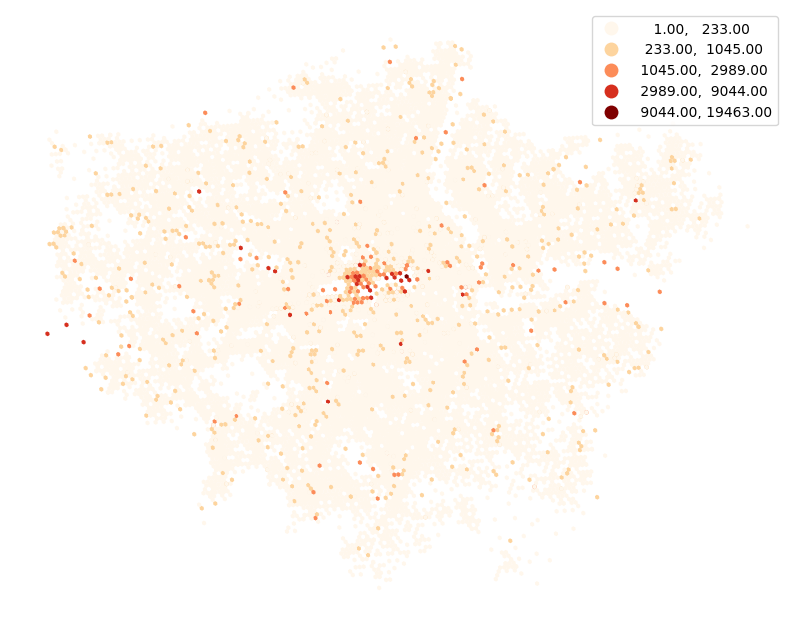

In [34]:
# plot the map, without axis, natural breaks
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
od_h3_count.plot(column='count_commuters', ax=ax, legend=True, scheme='fisherjenks', k=5, cmap='OrRd')
plt.axis('off')

In [35]:
# Export to geojson
od_h3_count.to_file(os.path.join('data','od_h3_count.geojson'), driver='GeoJSON')